# Predicting Heart Failure

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
set.seed(1)

In [3]:
weather <- read_csv("weather.csv")
weather

Parsed with column specification:
cols(
  date = col_date(format = ""),
  precipitation = col_double(),
  temp_max = col_double(),
  temp_min = col_double(),
  wind = col_double(),
  weather = col_character()
)



date,precipitation,temp_max,temp_min,wind,weather
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2012-01-01,0.0,12.8,5.0,4.7,drizzle
2012-01-02,10.9,10.6,2.8,4.5,rain
2012-01-03,0.8,11.7,7.2,2.3,rain
⋮,⋮,⋮,⋮,⋮,⋮
2015-12-29,0,7.2,0.6,2.6,fog
2015-12-30,0,5.6,-1.0,3.4,sun
2015-12-31,0,5.6,-2.1,3.5,sun


In [5]:
weather_split <- initial_split(weather, prop = 0.75, strata = weather)
weather_train <- training(weather_split)
weather_test <- testing(weather_split)
weather_train

date,precipitation,temp_max,temp_min,wind,weather
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2012-01-01,0.0,12.8,5.0,4.7,drizzle
2012-01-02,10.9,10.6,2.8,4.5,rain
2012-01-04,20.3,12.2,5.6,4.7,rain
⋮,⋮,⋮,⋮,⋮,⋮
2015-12-28,1.5,5.0,1.7,1.3,rain
2015-12-30,0.0,5.6,-1.0,3.4,sun
2015-12-31,0.0,5.6,-2.1,3.5,sun


date,precipitation,temp_max,temp_min,wind,weather,temp_diff
<date>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2012-01-01,0.0,12.8,5.0,4.7,drizzle,7.8
2012-01-02,10.9,10.6,2.8,4.5,rain,7.8
2012-01-04,20.3,12.2,5.6,4.7,rain,6.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2015-12-28,1.5,5.0,1.7,1.3,rain,3.3
2015-12-30,0.0,5.6,-1.0,3.4,sun,6.6
2015-12-31,0.0,5.6,-2.1,3.5,sun,7.7


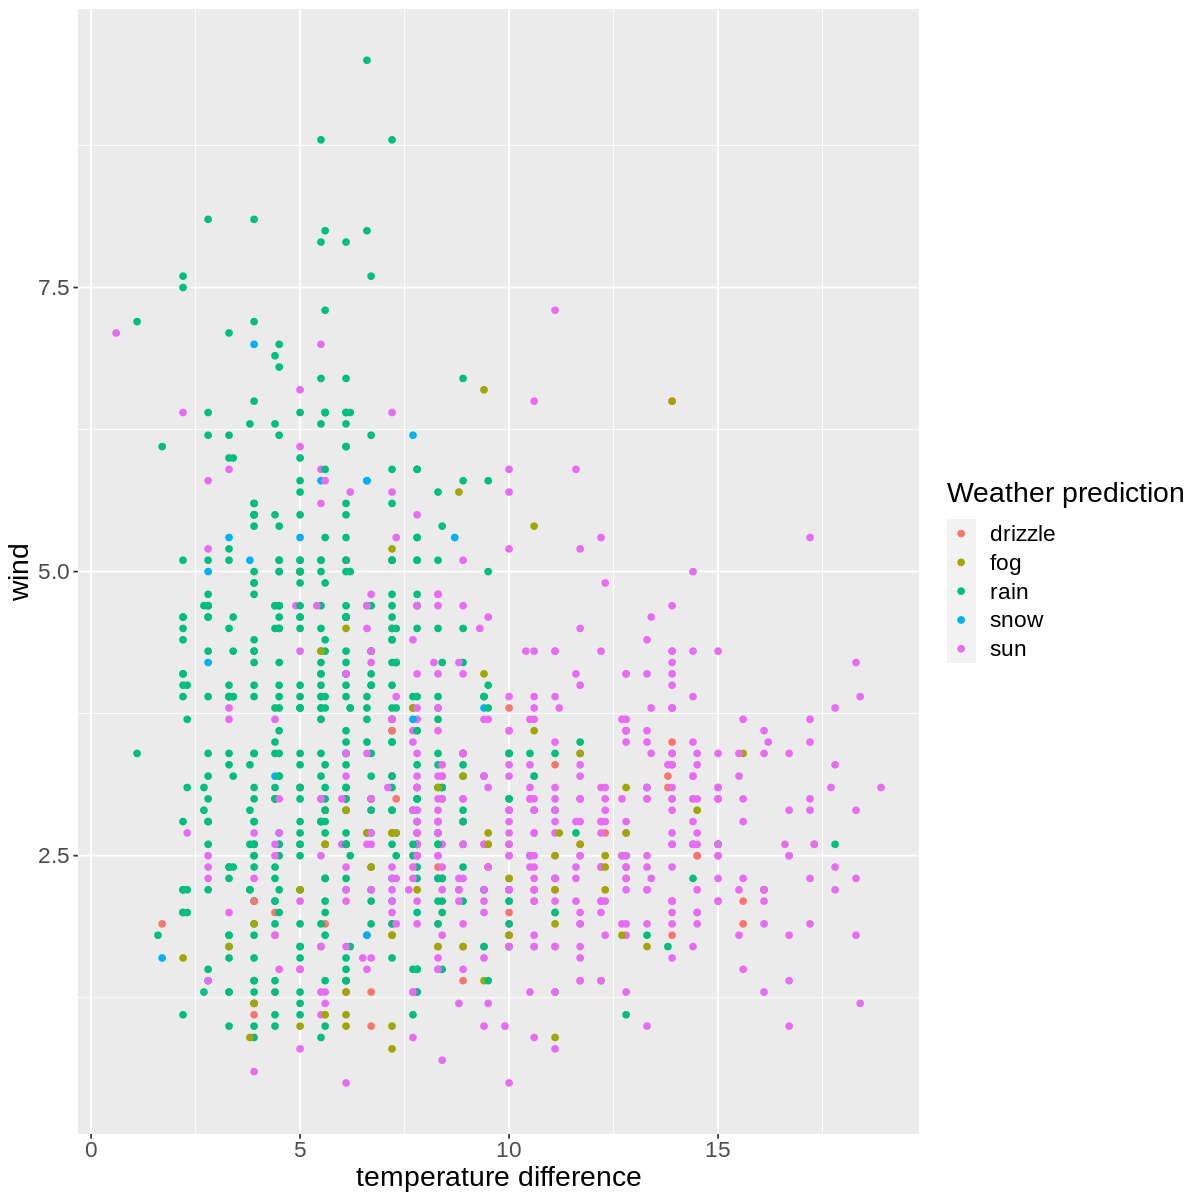

In [6]:
options(repr.plot.width = 10, repr.plot.height = 10) 
weather_prediction_mutate <- weather_train %>%
    mutate(temp_diff = temp_max-temp_min) 
weather_prediction_mutate
weather_prediction_graph <- weather_prediction_mutate %>%
    ggplot(aes(x = temp_diff, y = wind, colour=weather))  +
    geom_point(aes(colour=weather)) +
    labs(colour = "Weather prediction") +
    xlab("temperature difference") + 
    ylab("wind") +
    theme(text = element_text(size = 17))
weather_prediction_graph